# Computer Vision Project

### Setup

In [215]:
import os
import importlib
from tqdm import tqdm

# Torch modules
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch import amp

# Custom modules
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import preprocessing, model_utils

import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import PointDataset

from models.unet_model import UNET


In [216]:
# Defining some constants that will be used throughout the notebook
DATA_DIR = 'Dataset/'
x_test_dir = os.path.join(DATA_DIR, 'Test/color')
y_test_dir = os.path.join(DATA_DIR, 'Test/label')
x_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/color')
y_trainVal_dir = os.path.join(DATA_DIR, 'TrainVal/label')

### Splitting the TrainVal data into training and validation data
* Splitting into training and validations sets is needed so we can evaluate peformance on the model while training.
* More common than K-fold cross validation in deep learning settings because of computational costs.

In [217]:
# Getting a list of relative paths to the images (x) and the masks/labels (y)
x_test_fps, y_test_fps = preprocessing.get_testing_paths(x_test_dir, y_test_dir)

# Splitting relative path names into into training and validation
x_train_fps, x_val_fps, y_train_fps, y_val_fps = preprocessing.train_val_split(x_trainVal_dir, y_trainVal_dir, 0.2)


### Custom Dataset

In [218]:
test_augmentation = preprocessing.get_validation_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_augmentation = preprocessing.get_training_augmentation()


train_dataset = CVDataset(x_train_fps, y_train_fps, preprocessing=preprocessing_fn, augmentation=train_augmentation)
valid_dataset = CVDataset(x_val_fps, y_val_fps)

test_dataset  = CVDataset(
                x_test_fps[:10],
                y_test_fps[:10],
                augmentation = test_augmentation,
                preprocessing=preprocessing_fn
                )


# Printing the size of each dataset
print(f'Training dataset has size {train_dataset.__len__()}')
print(f'Validation dataset has size {valid_dataset.__len__()}')
print(f'Testing dataset has size {test_dataset.__len__()}')

Training dataset has size 2938
Validation dataset has size 735
Testing dataset has size 10


In [27]:
test_dataset.original_dimensions

[(473, 600),
 (383, 400),
 (225, 300),
 (225, 300),
 (300, 229),
 (300, 240),
 (279, 300),
 (278, 208),
 (375, 500),
 (300, 241)]

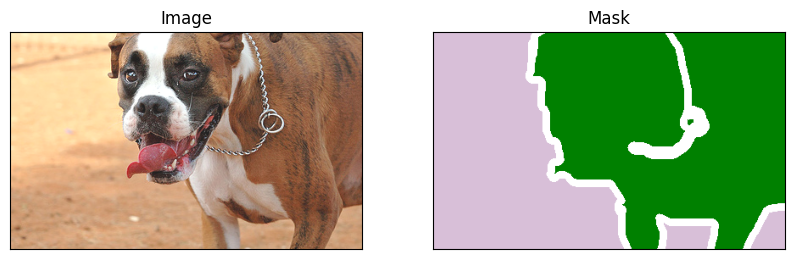

In [6]:

image, mask = train_dataset[23]
c_mask = colorise_mask(mask, VisualisationConstants.palette)
visualise_data(image = image, mask = c_mask)


In [273]:
colorise_mask(mask, VisualisationConstants.palette).shape

torch.Size([3, 256, 416])

## Saving the model

In [7]:
# 0. Create your model and train it
model = unet_model.UNET(in_channels=3, out_channels=3)
# train function/code or whatever you need to use

# 1. get the state dict for the model (weights etc)
#    This is a built in method if model inherits from nn.Module
state_dict = model.state_dict()

# 2. Create a checkpoint
checkpoint = {'state_dict': state_dict, # 'state_dict' key name must be named state_dict exactly
              'epochs':10,              # Add optional additional elements to the checkpoint for experiment tracking
              'learning_rate': 10}      # these can be named whatever you like, and there can be as many as you like

# 3. save the checkpoint to your computer/google colab files
model_utils.save_checkpoint(
    checkpoint,
    'test.pth'  # Where you want to save & filename, if you want to save to folder called 'checkpoints' for instance, just change to 'checkpoints/test.pth'
    )

=> Final model and metadata saved to test.pth


## Loading the model 

In [8]:
import segmentation.utils
importlib.reload(segmentation.utils)
from segmentation.utils import ModelEval

## Point based segmentation

In [13]:
import segmentation.dataset
importlib.reload(segmentation.dataset)
from segmentation.dataset import CVDataset
import segmentation.utils
importlib.reload(segmentation.utils)

import torchvision.transforms.functional as TF
import torch

In [14]:
train_aumentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
train_dataset = CVDataset(x_train_fps, y_train_fps, augmentation=train_aumentation)

In [15]:
from models.unet_model import UNET
model = UNET()

In [16]:
def predict(image, model, device="cuda" if torch.cuda.is_available() else "cpu"):
    '''
    Function that makes a predicted mask from the input image.

    # Parameters
        image: image of size (3, H, W)

    # Returns
        predicted mask of size (1, H, W)
    '''
    model.to(device)  # Ensure model is on the correct device
    model.eval()
    
    image = image.to(device)  # Move image to the same device as model

    # pred_logits from resized image (3, H, W) -> (1, 3, H, W)
    with torch.no_grad():  # Disable gradients for inference
        pred_logits = model(image.unsqueeze(0))
        pred_mask = torch.argmax(pred_logits, dim=1)

    return pred_mask

In [18]:
from segmentation.eval import *

In [19]:
new_func = prediction_wrapper(predict)

In [20]:
new_func(image, model = '')

AttributeError: 'str' object has no attribute 'to'

In [35]:
augmented_predict(image)

AttributeError: 'dict' object has no attribute 'to'

In [46]:
train_augmentation = preprocessing.get_training_augmentation()
preprocessing_fn = preprocessing.get_preprocessing()
val_augmentation = preprocessing.get_validation_augmentation()

train_dataset = PointDataset(x_train_fps[:5], y_train_fps[:5], augmentation=train_augmentation, preprocessing=preprocessing_fn, concat_heatmap=False)
val_dataset  = PointDataset(x_val_fps, y_val_fps, augmentation=val_augmentation, preprocessing=preprocessing_fn)

train_loader = DataLoader(train_dataset,batch_size= 8,num_workers=4,pin_memory=True,shuffle=True)

In [ ]:

import numpy as np

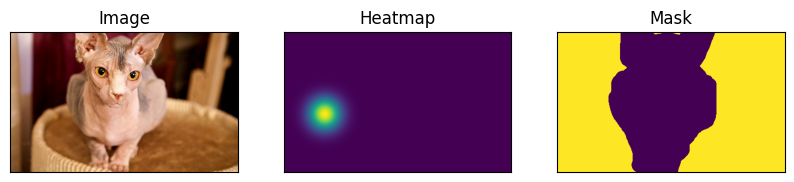

In [212]:
from segmentation.show import *
image, mask, heatmap = train_dataset[1]
heatmap = heatmap.numpy()


visualise_data(image = image, heatmap = heatmap, mask = mask)

In [78]:
np.unique(mask)

array([0, 1])

NameError: name 'MidFusionUNET' is not defined

In [ ]:
image.unq

tensor([[[ 5.0196e-01,  5.0196e-01,  5.3725e-01,  ...,  6.8627e-01,
           7.1765e-01,  7.4118e-01],
         [ 5.2549e-01,  5.2941e-01,  5.3333e-01,  ...,  7.2157e-01,
           7.3333e-01,  7.4118e-01],
         [ 4.9412e-01,  5.2157e-01,  5.8431e-01,  ...,  7.4510e-01,
           7.5294e-01,  7.6078e-01],
         ...,
         [ 8.4706e-01,  8.7451e-01,  8.9412e-01,  ...,  8.7451e-01,
           8.4706e-01,  8.5490e-01],
         [ 8.1961e-01,  8.6275e-01,  8.7843e-01,  ...,  8.5882e-01,
           8.5490e-01,  8.5882e-01],
         [ 8.2353e-01,  8.5490e-01,  8.6667e-01,  ...,  8.5490e-01,
           8.4706e-01,  8.3922e-01]],

        [[ 3.5294e-01,  3.5686e-01,  4.1176e-01,  ...,  3.9608e-01,
           4.3922e-01,  4.5882e-01],
         [ 3.6078e-01,  3.8431e-01,  4.4706e-01,  ...,  4.4314e-01,
           4.5490e-01,  4.7059e-01],
         [ 4.2745e-01,  3.7255e-01,  4.3922e-01,  ...,  4.6667e-01,
           4.7451e-01,  4.8627e-01],
         ...,
         [ 6.4706e-01,  6

In [15]:
from segmentation.eval import predict

In [17]:
image = image.float()
predict(image, unet_model)

tensor([[[1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         ...,
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1],
         [1, 1, 1,  ..., 1, 1, 1]]])